Begun March 28, 2022, 16:09.

Taking new files from ``ubuntu@madeline-01:~/20220228/timetree-mugration-region-5``: ``annotated_tree.nexus``, ``confidence.csv`` and ``GTR.txt``.  This is a 10-tip tree.

In [3]:
library(phangorn)
library(ggtreeExtra)
library(ggtree)
library(ggnewscale)
library(colorspace);
library(RColorBrewer);
library(dplyr)
library(tidyr)
library(ggplot2)
library(ggpubr)
library(stringr)
library(castor)
library(lubridate)
library(ramify)
library(ape)

Loading required package: ape

code for methods in class “Rcpp_Fitch” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_Fitch” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

ggtreeExtra v1.4.1  For help: https://yulab-smu.top/treedata-book/

If you use ggtreeExtra in published research, please cite the paper:

S Xu, Z Dai, P Guo, X Fu, S Liu, L Zhou, W Tang, T Feng, M Chen, L Zhan, T Wu, E Hu, Y Jiang, X Bo, G Yu. ggtreeExtra: Compact visualization of richly annotated phylogenetic data. Molecular Biology and Evolution 2021, 38(9):4039-4042. doi: 10.1093/molbev/msab166



ggtree v3.2.1  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpb

In [4]:
tree <- "annotated_tree.nexus"
confidence <- "confidence.csv"
gtr_file <- "GTR.txt"
cog_meta <- "/home/madeline/Desktop/git_temp/QIB_Internship/data/cog_global_2022-02-06_public.csv.xz"

In [5]:
tre0 <- read.nexus(tree) #timetree mugration output
tbl1 <- read.csv(confidence)
cog <- read.csv(cog_meta,sep=",")

Subset COG-UK metadata:

In [21]:
treetips <- str_replace_all(tre0$tip.label, "_", "/")
cog <- cog[ cog$sequence_name %in% treetips,] #subset the big .xz file by your leaf tips
cog$code <- substr(cog$central_sample_id,1,4)

Get one-letter codes for nodes and tips, from ``confidence.csv``

In [22]:
df <- data.frame(tbl1)
Node <- as.character(df[,'X.name'])

df$X.name <- NULL
Letter <- colnames(df)[max.col(df,ties.method="first")]

confidence <- as.data.frame(cbind(Node, Letter))

Get four-letter codes from ``gtr.txt``

In [23]:
gtr <- read.csv(gtr_file,sep=":")
stopping_place <- which(gtr$Character.to.attribute.mapping == "Substitution rate (mu)")
gtr <- gtr[1:stopping_place[1]-1, ]
names(gtr)[names(gtr) == 'Character.to.attribute.mapping'] <- 'Letter'
names(gtr)[names(gtr) == 'X'] <- 'Code'
rownames(gtr) <- c()
#remove spaces
gtr$Letter <- gsub('\\s+', '', gtr$Letter)
gtr$Code <- gsub('\\s+', '', gtr$Code)

Merge dataframes:

In [24]:
total <- merge(gtr,confidence,by="Letter")
total

Letter,Code,Node
<chr>,<chr>,<chr>
A,ALDP,NODE_0000000
A,ALDP,England_ALDP-2FE62BA_2021
A,ALDP,NODE_0000001
A,ALDP,England_ALDP-308716F_2021
B,HSLL,England_HSLL-3411A10_2022
C,LOND,England_LOND-YYBNE1Q_2022
C,LOND,NODE_0000007
D,MILK,England_MILK-3128D5C_2022
D,MILK,England_MILK-307D409_2021


To plot things, I just need the node labels:

In [47]:
node_labels <- total[grep("NODE", total$Node), ]
rownames(node_labels) <- c()
names(node_labels)[names(node_labels) == 'Node'] <- 'newick_label'
node_labels = node_labels[,c('newick_label','Code','Letter')]
node_labels

newick_label,Code,Letter
<chr>,<chr>,<chr>
NODE_0000000,ALDP,A
NODE_0000001,ALDP,A
NODE_0000007,LOND,C
NODE_0000006,MILK,D
NODE_0000002,NORW,E
NODE_0000003,NORW,E
NODE_0000004,NORW,E
NODE_0000005,NORW,E


Now, finally, plot the tree, coloring the tips by code...

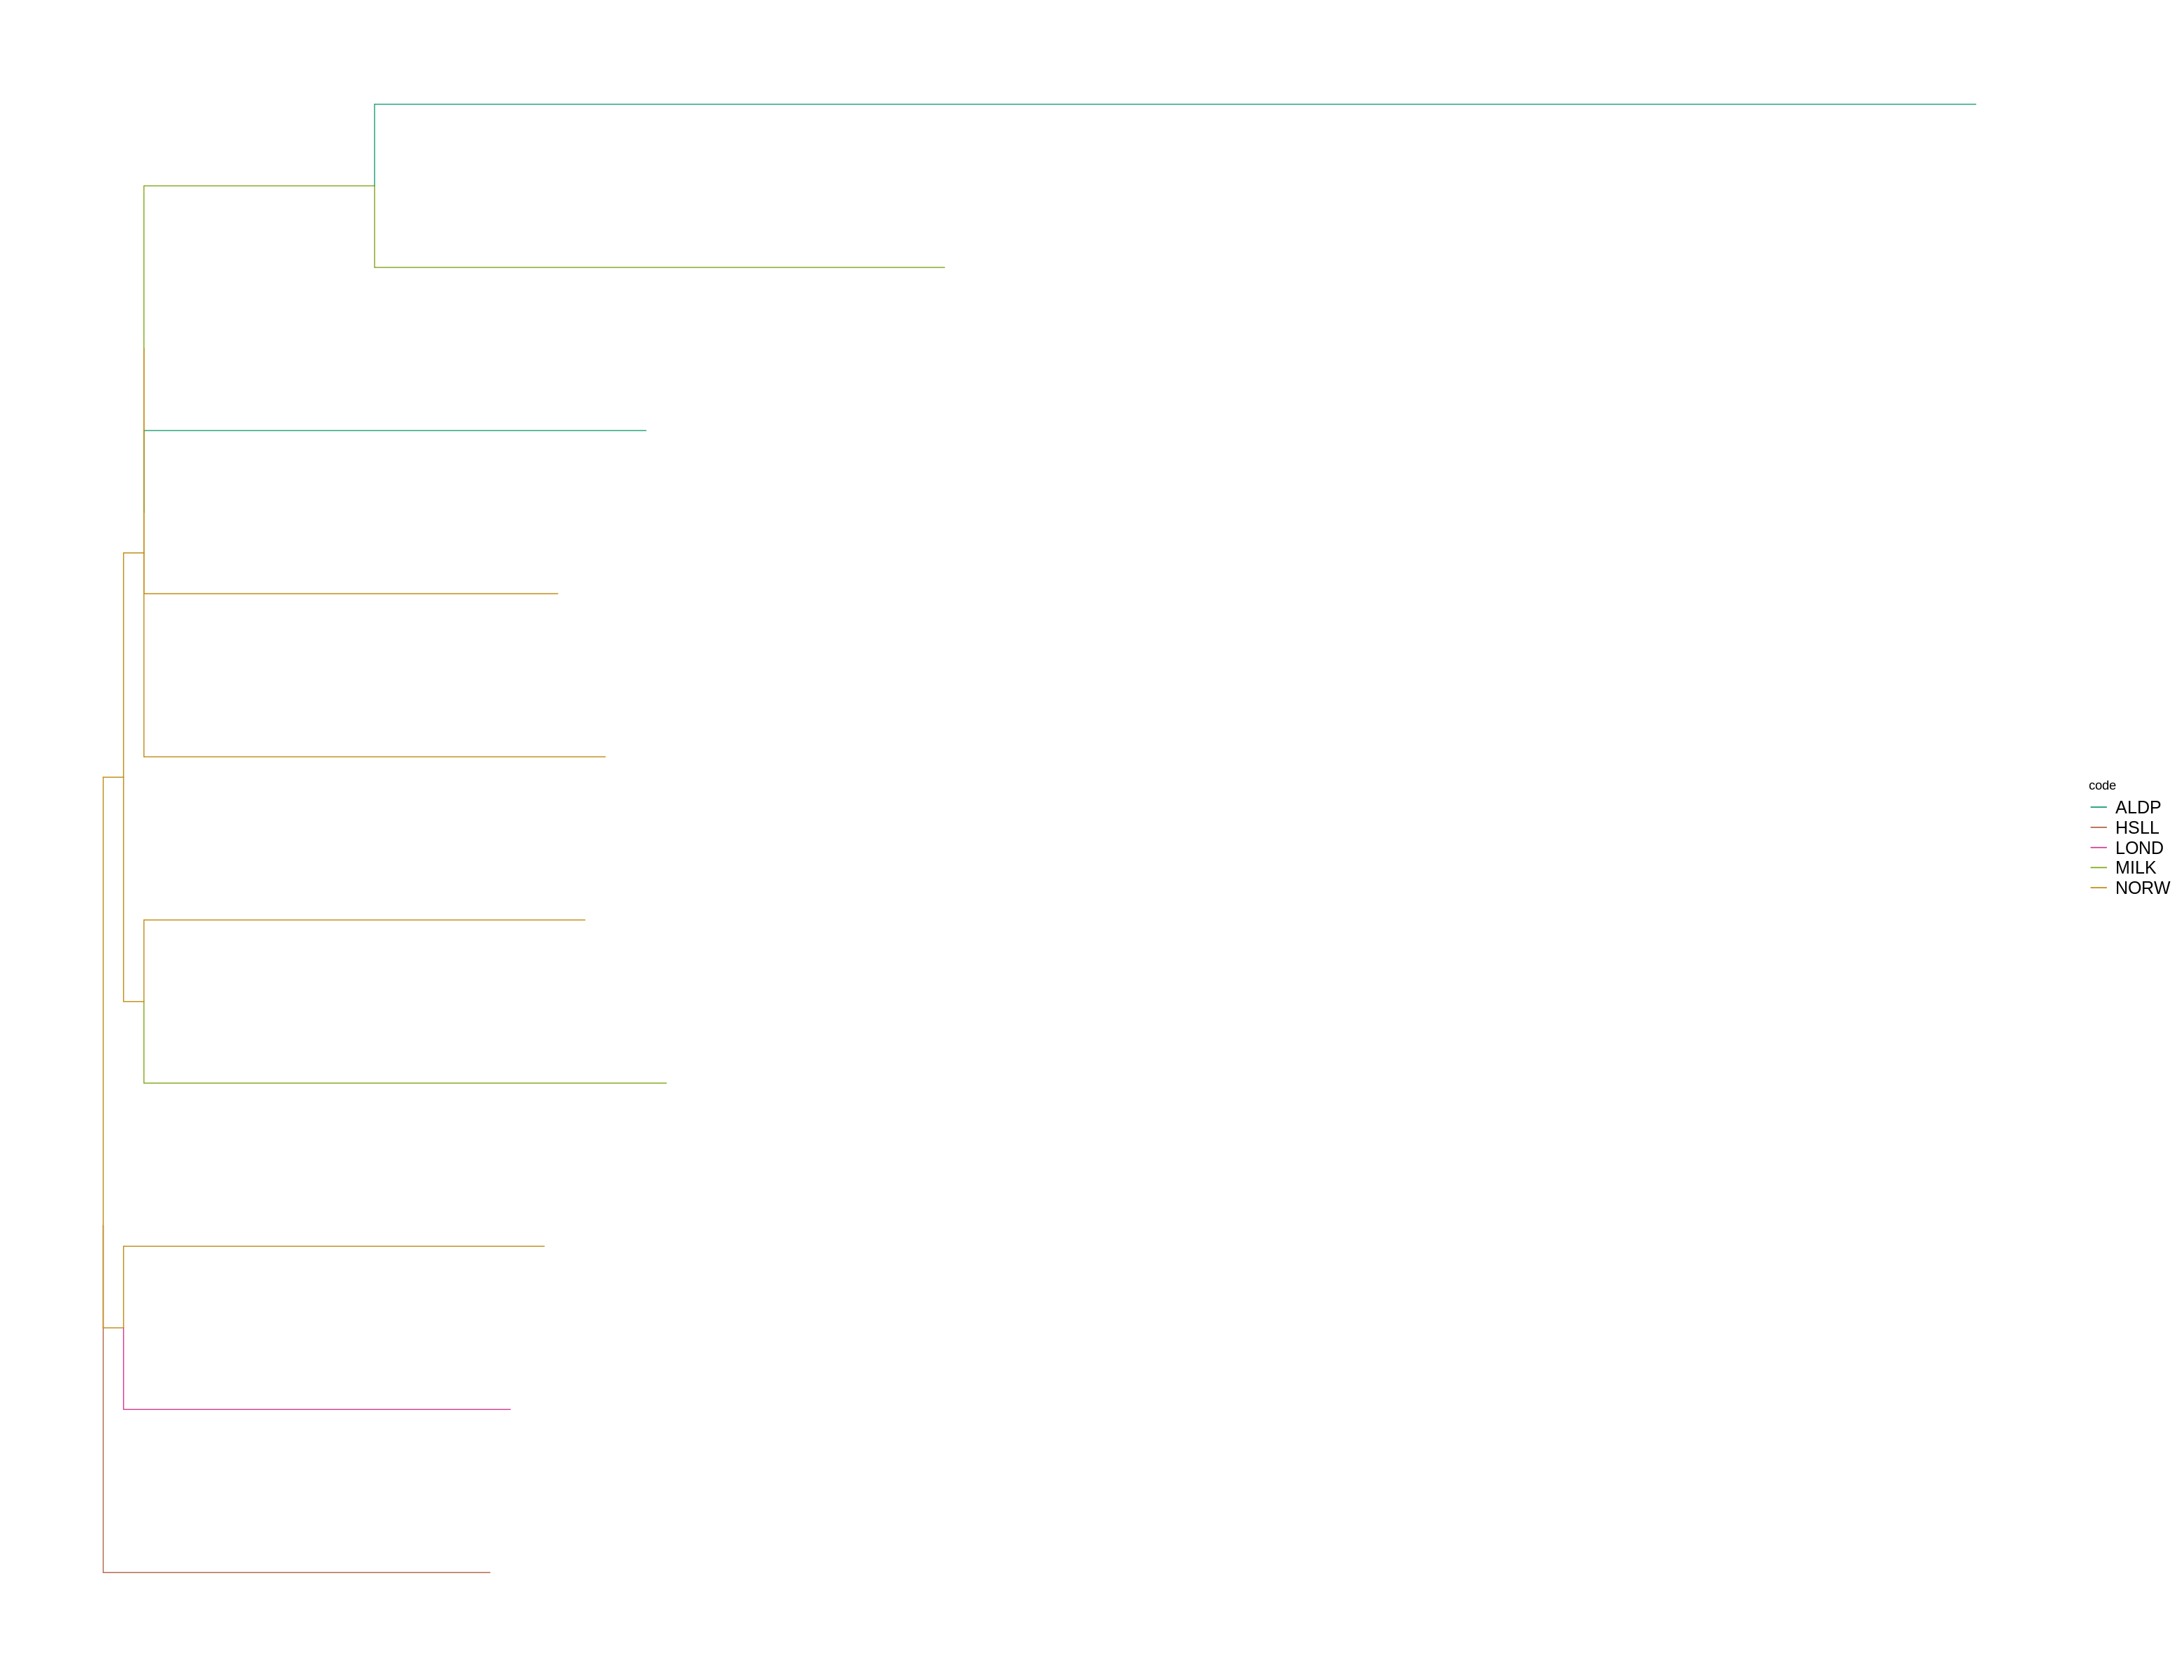

In [48]:
traits <- cog
rownames(traits) <- traits$sequence_name

# get plot inputs
groupInfo <- split (tre0$tip.label, traits["code"])
grouptre <- groupOTU(tre0, groupInfo, group_name="group1")
options(repr.plot.width=26, repr.plot.height=20) ; par(oma=c(0,0,0,0)) 
getPal_1 = colorRampPalette( brewer.pal(8,"Dark2"))(length(unique(traits[,"code"]))+1)  ## RdYlGn Set2

# make plot
p <- ggtree (grouptre,  aes(color=group1),size=0.4, layout="rectangular") + theme(legend.position="right") + theme(legend.text=element_text(size=15))
p <- p + ggplot2::scale_color_manual(values = getPal_1, name="code")
p <- p + new_scale_color()  + new_scale_fill() 
p

Now label the nodes.  (Annotating nodes tutorial is here: https://yulab-smu.top/treedata-book/chapter7.html)

Warning message:
“Removed 10 rows containing missing values (geom_label).”


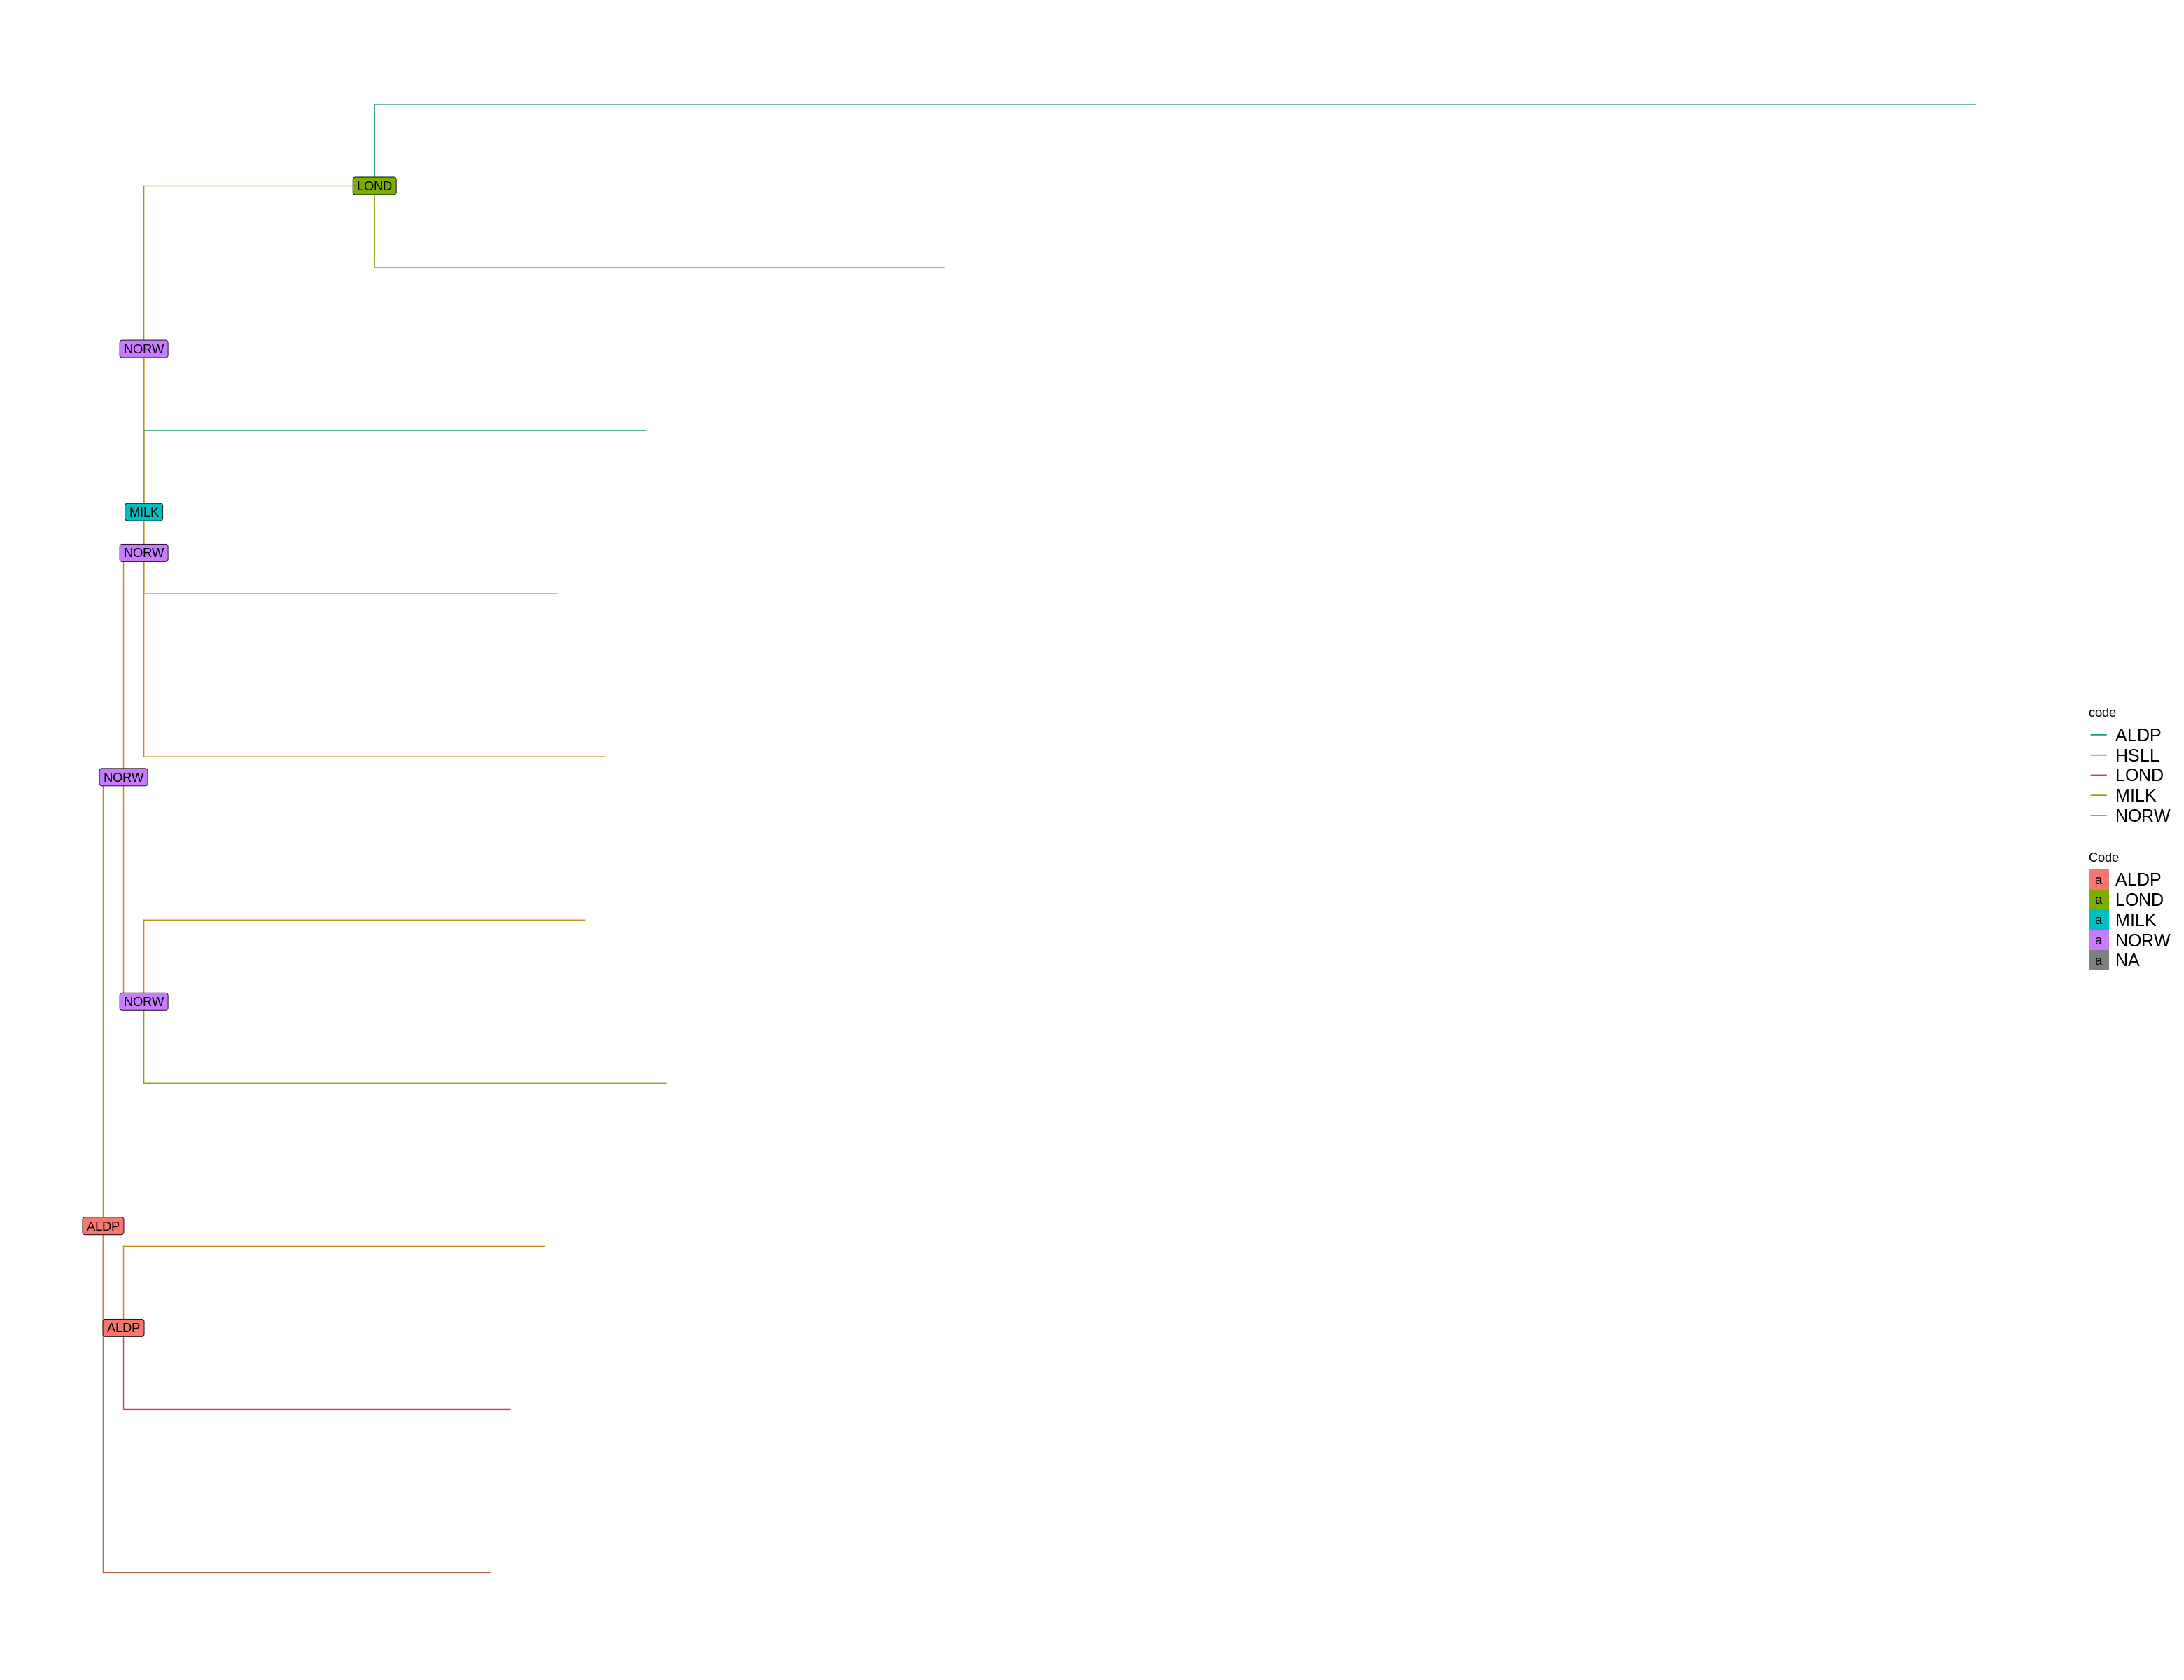

In [51]:
p %<+% node_labels + 
    geom_label(aes(label = Code, fill = Code))

# add same coloring for node labels as for tips